In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

import tensorflow as tf

# Set some parameters

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

TRAIN_PATH = "/content/drive/My Drive/train_images"
TRAIN_MASK_PATH = "/content/drive/My Drive/training_masks"
TEST_PATH = "/content/drive/My Drive/test_images"
VALIDATION_PATH = "/content/drive/My Drive/val_images"
VALIDATION_MASK_PATH = "/content/drive/My Drive/val_masks"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [0]:
#GET IDS

train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)
train_mask_ids = os.listdir(TRAIN_MASK_PATH)

val_ids = os.listdir(VALIDATION_PATH)
val_mask_ids = os.listdir(VALIDATION_MASK_PATH)


In [0]:
#GET X_TRAIN AND Y_TRAIN
#X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sys.stdout.flush()
for i in range(0,1500): 
    path = TRAIN_PATH + '/' + "train_img_" + str(i+1) + ".jpg"
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    path_mask = TRAIN_MASK_PATH + '/' + "train_mask_" + str(i+1) + ".jpg"
    img_mask = imread(path_mask)
    img_mask = resize(img_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mask = np.expand_dims(resize(img_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[i] = img_mask



In [0]:
#GET VALIDATION IMAGES
X_val = np.zeros((len(val_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((len(val_mask_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
sys.stdout.flush()
for i in range(1,500): 
    path = VALIDATION_PATH + '/' + "validation_img_" + str(i) + ".jpg"
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_val[i] = img

    path_mask = VALIDATION_MASK_PATH + '/' + "validation_mask_" + str(i) + ".jpg"
    img_mask = imread(path_mask)
    img_mask = resize(img_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mask = np.expand_dims(resize(img_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_val[i] = img_mask

In [0]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
for i in range(0,927):
    path = TEST_PATH + '/' + "test_img_" + str(i+1) + ".jpg"
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    sizes_test.append([img.shape[0], img.shape[1]])
    X_test[i] = img

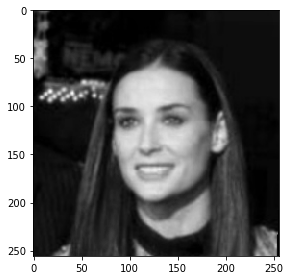

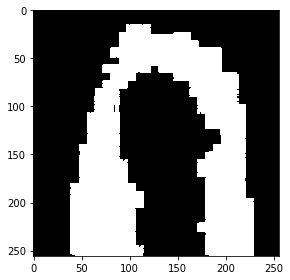

In [0]:
#CHECK TRAIN IMAGES
ix = random.randint(0, len(X_train))
#ix = 1
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

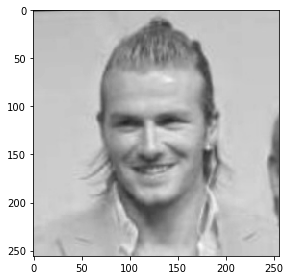

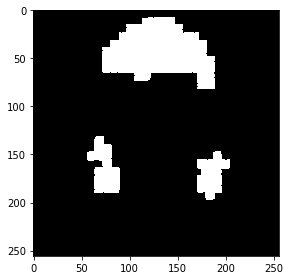

In [0]:
#CHECK VALIDATION IMAGES
ix = random.randint(0, len(X_val))
#ix = 5
imshow(np.squeeze(X_val[ix]))
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# IMPROVED MODEL
inputs = Input((256, 256, IMG_CHANNELS))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
up6 = BatchNormalization()(up6)
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
up7 = BatchNormalization()(up7)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
up8 = BatchNormalization()(up8)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
up9 = BatchNormalization()(up9)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
#model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
# U NET MODEL

# Build U-Net model
inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

In [0]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-cs4990.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_data=(X_val,Y_val), batch_size=16, epochs=40) #,callbacks=[earlystopper, checkpointer])
#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=15, callbacks=[earlystopper, checkpointer])


In [0]:
# USE MODEL TO PREDICT

preds_test = model.predict(X_test, verbose=1)

927/927 [==============================] - 8s 8ms/step


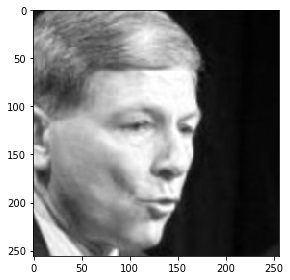

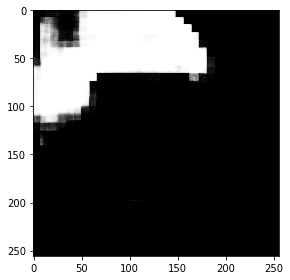

In [0]:
# CHECK THE PREDICTIONS VISUALLY

ix = random.randint(0, len(X_test))
#ix = 1
ix = ix-1
imshow(np.squeeze(X_test[ix]))
plt.show()
imshow(np.squeeze(preds_test[ix]))
plt.show()


In [0]:
# SAVE RGB IMAGES TO A FOLDER

for i in range(0,927):
  plt.imsave(os.path.join('rgb_test_masks', 'test_mask_' + str(i+1) + '.jpg'),np.squeeze(preds_test[i]))


In [0]:
# CONVERT RGB IMAGES TO GRAYSCALE

from PIL import Image
#import pytesseract
for i in range(0,927):
  image_file = Image.open('/content/rgb_test_masks/test_mask_' + str(i+1) +'.jpg')
  image_file = image_file.convert('L')

  image_file = image_file.resize((250,250),Image.ANTIALIAS)

  image_file.save('/content/bw_test_masks/test_mask_' + str(i+1) +'.jpg')


CONVERT MASKS TO CSV

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
from skimage import color

%matplotlib inline  

# encoding function
# based on the implementation: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python/code
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [0]:
# (* update) the input_path using your folder path
input_path = "/content/bw_test_masks"

# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))



# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(input_path, file))
    
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)

    encodings.append(rle_encoding(mask))





# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('sample_data', 'validation_masks.csv'), index=False)

In [0]:
!zip -r /content/file.zip /content/bw_test_masks/